##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Состязательный пример использования FGSM

В этом руководстве создается состязательный пример с использованием атаки методом быстрого градиента со знаком (FGSM), как описано в разделе [Объяснение и использование состязательных примеров](https://arxiv.org/abs/1412.6572) Гудфеллоу и др. Это была одна из первых и самых популярных атак с целью обмануть нейронную сеть.

---
*Градиент со знаком - это вычисленное приращение весов, которому присваивается знак
"плюс" или "минус", в зависимости от того, правильно, или неправильно классифицирован обучающий пример.*

---

## Что такое состязательный пример?

**Состязательные примеры** — это специализированные входные данные, созданные с целью запутать нейронную сеть, и привести ее к неправильной классификации входных данных. Эти входные данные неразличимы для человеческого глаза, но из-за них сеть не может идентифицировать содержимое изображения. Существует несколько типов таких атак, однако здесь основное внимание уделяется атаке методом  быстрого градиента со знаком, которая представляет собой атаку «белого ящика», цель которой — обеспечить неправильную классификацию. Атака белого ящика — это когда злоумышленник имеет полный доступ к атакуемой модели. Один из самых известных примеров состязательного изображения, показанный ниже, взят из вышеупомянутой статьи.

![Adversarial Example](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/adversarial_example.png?raw=1)

Здесь, взяв изображение панды, злоумышленник добавляет небольшие возмущения (искажения) к исходному изображению, в результате чего модель с высокой степенью достоверности маркирует это изображение как гиббона. Процесс добавления этих возмущений объясняется ниже.

## Метод быстрого градиентного знака
Метод быстрого знака градиента использует градиенты нейронной сети для создания состязательного примера. Для входного изображения метод использует градиенты потерь по отношению к входному изображению, чтобы создать новое изображение, которое максимизирует потери. Этот новый образ называется имиджем противника. Это можно резюмировать, используя следующее выражение:

$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

где

*   adv_x : изображение-конкурент.
*   x : Оригинальное входное изображение.
*   y : Оригинальная входная метка.
*   $\epsilon$ : Множитель, гарантирующий, что возмущения малы.
*   $\theta$ : Веса модели.
*   $J$ : функция потерь.

Интригующим свойством здесь является тот факт, что градиенты берутся относительно входного изображения. Цель этого действия - создать изображение, которые максимизирует значение функции потерь. Метод выясняет, сколько каждый пиксель изображения вносит вклад в значение потерь, и соответственно добавляет возмущение. Он работает довольно быстро, потому что легко определить, какой вклад в потери вносит каждый входной пиксель, находя необходимые градиенты. Следовательно, градиенты берутся относительно изображения. Кроме того, поскольку модель в этот момент не обучается (то есть, градиент не влияет на веса модели), и поэтому веса модели остаются постоянными. Единственная цель — обмануть уже обученную модель.


Итак, давайте попробуем обмануть предварительно обученную модель. В этом уроке модель [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, обученная на наборе данных [ImageNet](http://www.image-net.org/).

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Загрузим предварительно обученную модель MobileNetV2 и имена классов ImageNet.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Вспомогательная функция для предварительной обработки изображения, чтобы его можно было ввести в MobileNetV2.
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Вспомогательная функция для извлечения меток из вектора вероятности
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Исходное изображение
Воспользуемся образцом изображения [лабрадора-ретривера](https://www.google.com/url?q=https%3A%2F%2Fcommons.wikimedia.org%2Fwiki%2FFile%3AYellowLabradorLooking_new.jpg) из Wikimedia Common и создадим на его основе состязательные примеры.

Первый шаг - предварительная обработка, чтобы его можно было использовать в качестве входных данных для модели MobileNetV2.

In [ ]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Let's have a look at the image.

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


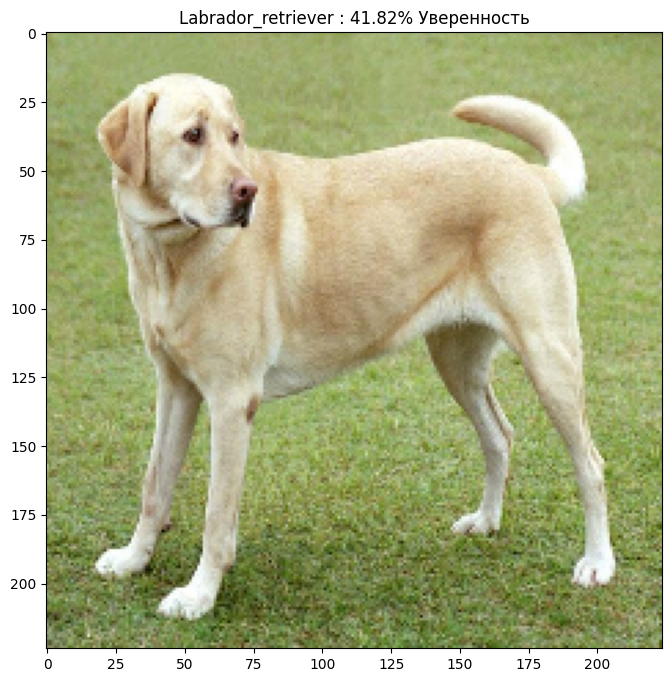

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # Изменить [-1, 1] на [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Уверенность'.format(image_class, class_confidence*100))
plt.show()

## Создание конкурентного изображения

### Реализация метода быстрого градиента со знаком
Первый шаг — создать возмущения, которые будут использоваться для искажения исходного изображения, что приведет к созданию состязательного изображения. Как уже упоминалось, для этой задачи градиенты берутся относительно изображения.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Получим градиенты потерь относительно входного изображения.
  gradient = tape.gradient(loss, input_image)
  # Получите знаки градиентов, чтобы создать возмущение.
  signed_grad = tf.sign(gradient)
  return signed_grad

Возникающие в результате возмущения также можно визуализировать.

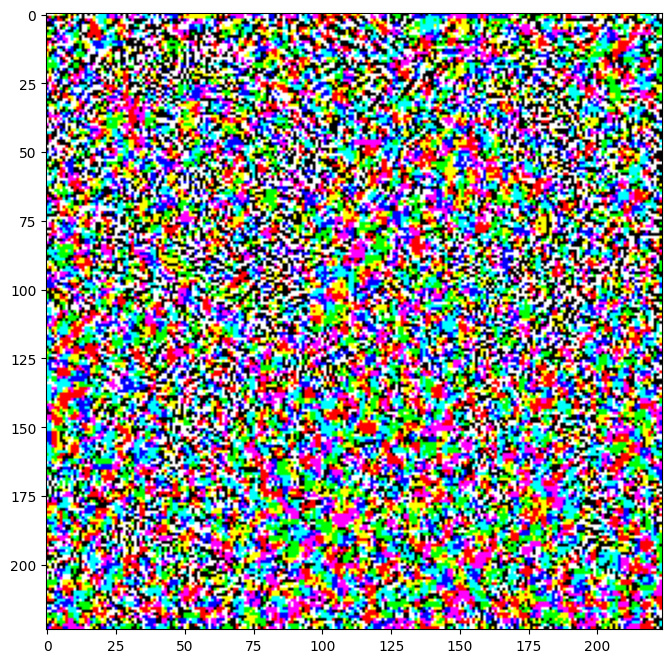

In [ ]:
# Получим входную метку изображения.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # Изменить [-1, 1] на [0,1]

Давайте попробуем это для разных значений эпсилон и посмотрим на полученное изображение. Вы заметите, что по мере увеличения значения эпсилона обмануть сеть становится легче. Однако здесь потребуется найти компромисс, при котором возмущения будут более идентифицируемыми.

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Уверенность'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


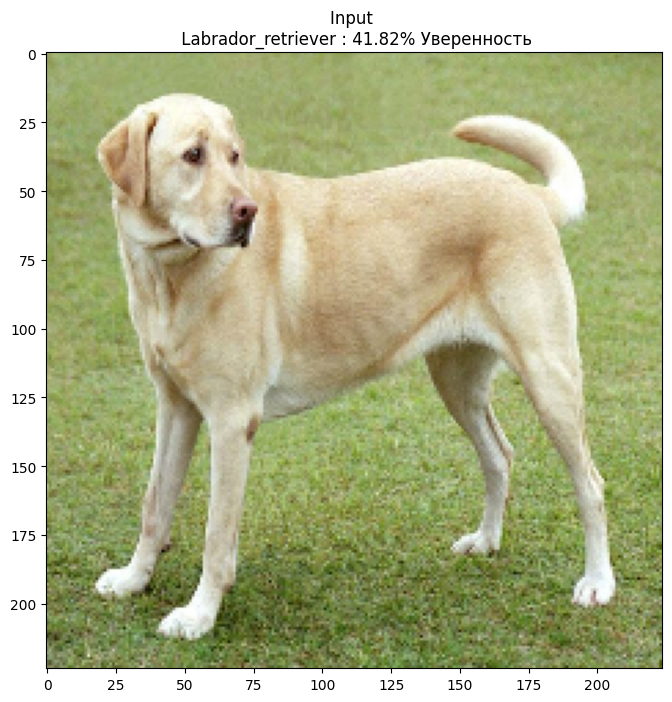

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


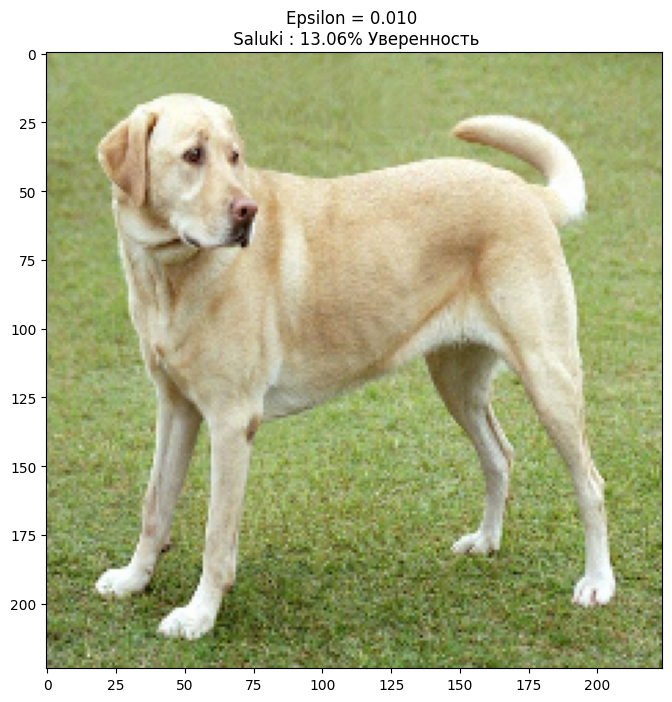

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


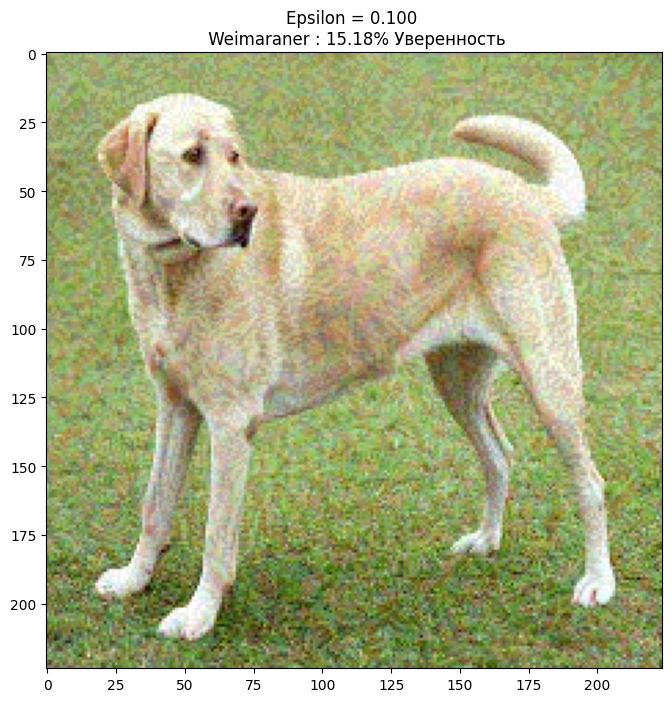

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


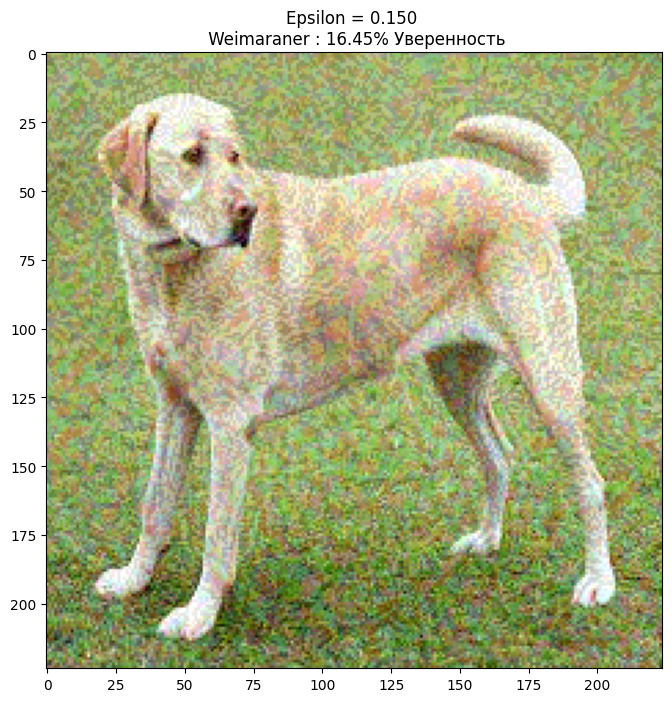

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## Следующие шаги
Теперь, когда вы знаете о состязательных атаках, попробуйте это на разных наборах данных и разных архитектурах. Вы также можете создать и обучить свою собственную модель, а затем попытаться обмануть ее, используя тот же метод. Вы также можете попробовать посмотреть, как меняется достоверность предсказаний при изменении эпсилона.

Несмотря на свою мощь, атака, показанная в этом руководстве, была только началом исследования состязательных атак, и с тех пор было опубликовано множество статей, создающих более мощные атаки. Помимо состязательных атак, исследования также привели к созданию средств защиты, целью которых является создание надежных моделей машинного обучения. Вы можете просмотреть этот [обзорный документ](https://arxiv.org/abs/1810.00069), чтобы получить полный список состязательных атак и защит.

Для многих других реализаций состязательных атак и защиты вы можете ознакомиться с библиотекой состязательных примеров [CleverHans](https://github.com/tensorflow/cleverhans).

In [ ]:
!wget https://huggingface.co/veriga/pneumo/resolve/main/pneumonia.zip

--2024-09-23 17:07:27--  https://huggingface.co/veriga/pneumo/resolve/main/pneumonia.zip
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.80, 18.239.50.49, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/9e/83/9e835eed98d793ae500e08c12312e6388b04409cae94108f95c1368f99840a86/0a28b1fd1d0820bb887645a98b862331aeb5aa351a376a7cedadd0447d01a899?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pneumonia.zip%3B+filename%3D%22pneumonia.zip%22%3B&response-content-type=application%2Fzip&Expires=1727370448&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNzM3MDQ0OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzllLzgzLzllODM1ZWVkOThkNzkzYWU1MDBlMDhjMTIzMTJlNjM4OGIwNDQwOWNhZTk0MTA4Zjk1YzEzNjhmOTk4NDBhODYvMGEyOGIxZmQxZDA4MjBiYjg4NzY0NWE5OGI4NjIzMzFhZWI1YWEzNTFhMzc2Y

In [ ]:
!unzip -x /content/pneumonia.zip

Archive:  /content/pneumonia.zip
  inflating: pneumonia.PNG           
  inflating: model_pneumonia.h5      
  inflating: normal.PNG              


In [ ]:
# Available backend options are: "jax", "tensorflow", "torch".
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

model = keras.saving.load_model("/content/model_pneumonia.h5")


In [ ]:
model.input_shape

(None, 224, 224, 3)

In [ ]:
image_path = "/content/pneumonia.PNG"
image_raw = tf.io.read_file(image_path)
image_pneumonia = tf.image.decode_image(image_raw)
image_pneumonia = tf.image.resize(image_pneumonia,(224,224))
image_pneumonia=tf.cast(image_pneumonia[:,:,:3],tf.float32)/255
image_pneumonia = tf.expand_dims(image_pneumonia,axis=0)

image_path = "/content/normal.PNG"
image_raw = tf.io.read_file(image_path)
image_normal = tf.image.decode_image(image_raw)
image_normal = tf.image.resize(image_normal,(224,224))
image_normal=tf.cast(image_normal[:,:,:3],tf.float32)/255
image_normal = tf.expand_dims(image_normal,axis=0)

ds = tf.concat([image_normal,image_pneumonia],axis=0)

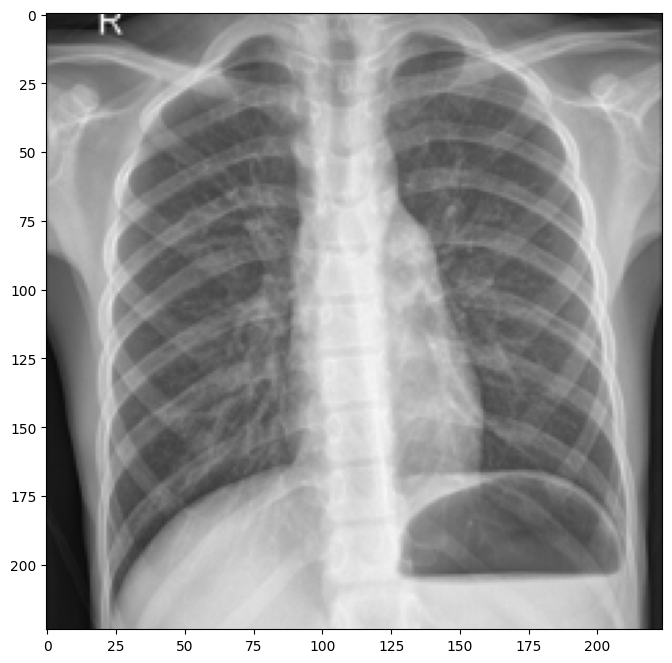

In [ ]:
plt.imshow(ds[0])

In [ ]:
labels = ['normal','pneumonia']


In [ ]:
results = model.predict(ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Получим градиенты потерь относительно входного изображения.
  gradient = tape.gradient(loss, input_image)
  # Получите знаки градиентов, чтобы создать возмущение.
  signed_grad = tf.sign(gradient)
  return signed_grad

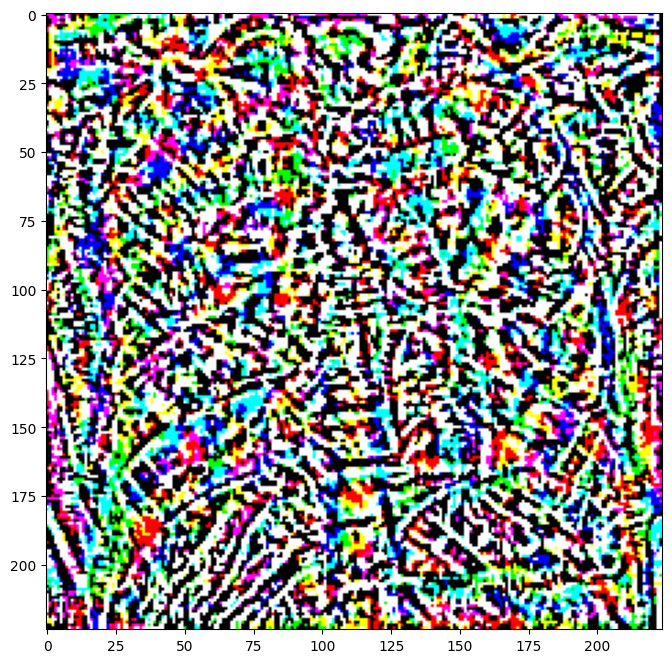

In [ ]:
normal_index = 0
label = tf.one_hot(normal_index, results.shape[-1])
label = tf.reshape(label, (1, results.shape[-1]))
perturbations = create_adversarial_pattern(image_normal, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # Изменить [-1, 1] на [0,1]


In [ ]:
def display_images(image, description):
  results = model.predict(image)
  label = labels[num_class]
  class_confidence = results[0, num_class] * 100
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Уверенность'.format(description,
                                                   label, class_confidence))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


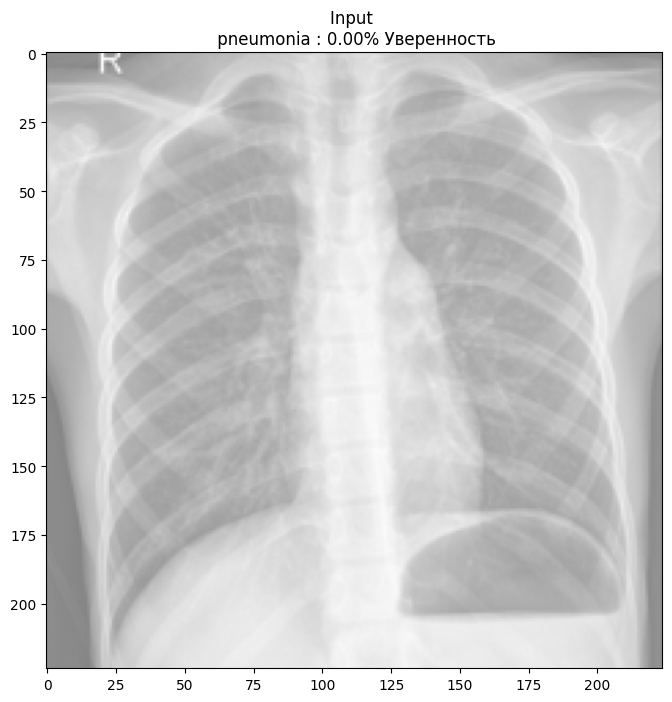

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


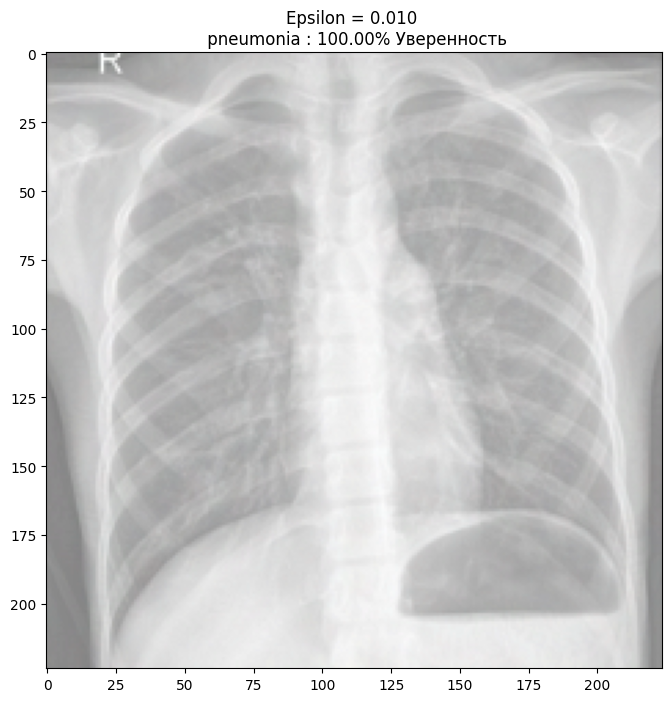

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


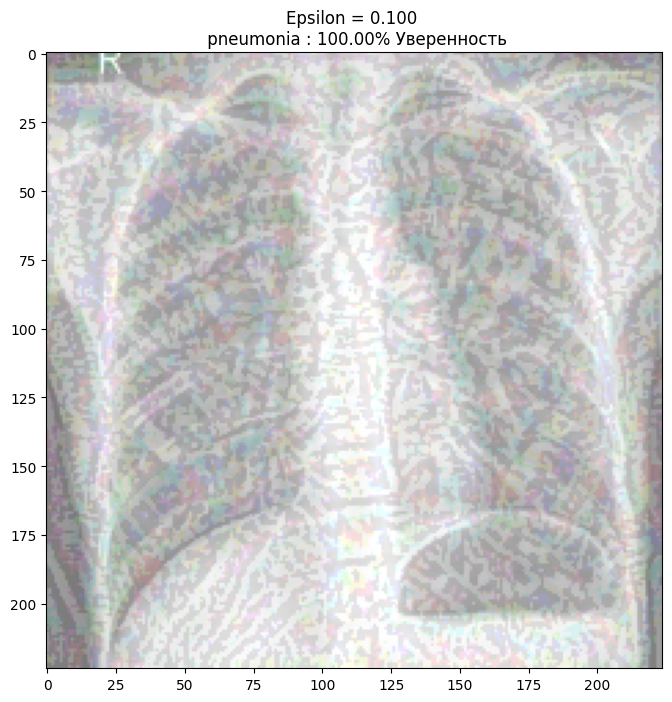

In [ ]:

epsilons = [0, 0.01, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image_normal + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])
